In [1]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from entsoe2 import fetch_entsoe_data
from n_trim import drop_buses
from zones import assign_zones
from load_weighting import load_weight
from production_weighting import production_weight, storage_weight
from drop_buses import drop_buses
from DC_links_add import DC_links_add
from Add_key_generators import add_other_generators_Nordic, add_ror_generators_NO
from Plotting import plot_network_with_loadings
from Loading_lines_and_links_relative_quantified import loading_lines_and_links_relative_quantified
from Merge_technologies import merge_technologies
from DK_1_cleanup import dk_1_cleanup
from Distribute_generation_load import distribute_generation_load
from Capacity_check_per_zone import capacity_check_per_zone
from DC_links_modifications_power_distr import dc_links_modifications_power_distr
import os


1. Importing nordic grid from pypsa eur ex DC links to non-nordic countries

In [2]:
n = pypsa.Network("base_s_65_elec_.nc")
#n.generators.columns

<frozen importlib._bootstrap>:488: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

INFO:pypsa.network.io:New version 1.0.2 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores


2. Assign zone column to loads. Drop H2 and battery buses. Adding generators with carrier 'other' to every bus, and 'ror' to NO_3 and NO_4. Adding load_Weight for buses and producdtion weight for generators.

In [3]:
n = assign_zones(n)

drop_buses(n)
add_other_generators_Nordic(n)
add_ror_generators_NO(n)

load_weight(n)
#n.buses
#Replace with production_weighting evetually. Needs to be done after we have added generators we want to include in the share calculation.
production_weight(n)
storage_weight(n)
#n.generators
#n.generators.columns ok now. No Zone or Technology yet
#n.storage_units.columns

✅ Added 65 new 'other' PQ generators.
Found 6 buses in NO_3
Found 6 buses in NO_4


PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 65
 - Carrier: 23
 - Generator: 455
 - Line: 101
 - Link: 7
 - Load: 65
 - StorageUnit: 62
Snapshots: 24

3. Remove all from node in west denmark and add a slack generator

In [4]:
dk_1_cleanup(n)

Found 1 buses in DK_1 zone
Removed 10 generators from DK0 0
Removed 1 loads from DK0 0
✅ Added slack generator to DK0 0


4. Fetch the ENTSOE-E data regarding AC flow, DC flow, load and production per bidding zone. Can be very time consuming, think about wether you need to do this or not. 
Use this if you want to collect data from other dates. Set run_fetch_entsoe = True if you want to run API call.
Use load from csv cells if you do not want to use other dates. 

In [5]:
run_fetch_entsoe = False
if run_fetch_entsoe:
    loads_df, gens_df, ac_flows_df, dc_flows_df = fetch_entsoe_data(start_date="2023-07-01", timezone="Europe/Oslo")
    loads_df.to_csv("loads_df_user_specific.csv")
    gens_df.to_csv("gens_df_user_specific.csv")
    ac_flows_df.to_csv("ac_flows_user_specific.csv")
    dc_flows_df.to_csv("dc_flows_user_specific.csv")
    season = "custom"

#Use save_multiindex_csv and load_multiindex_csv to save and load DataFrames with MultiIndex columns. Load we use anyways. Save you use if you want to save the data you collect using API. 
def save_multiindex_csv(df, filename):
    df.to_csv(filename, index=True)

def load_multiindex_csv(filename):
    return pd.read_csv(filename, header=[0, 1], index_col=0, parse_dates=True)

In [ ]:
season = "winter"  # Change to "summer" for summer data, change to some random string if you want to use user specific data. 
if season == "winter":
    loads_df = pd.read_csv("loads_df_winter.csv", index_col=0, parse_dates=True)
    ac_flows_df = pd.read_csv("ac_flows_df_winter.csv", index_col=0, parse_dates=True)
    dc_flows_df = pd.read_csv("dc_flows_df_winter.csv", index_col=0, parse_dates=True)
    gens_df = load_multiindex_csv("gens_df_winter.csv")
    n.set_snapshots(gens_df.index)

elif season == "summer":
    loads_df = pd.read_csv("loads_df_summer.csv", index_col=0, parse_dates=True)
    ac_flows_df = pd.read_csv("ac_flows_df_summer.csv", index_col=0, parse_dates=True)
    dc_flows_df = pd.read_csv("dc_flows_df_summer.csv", index_col=0, parse_dates=True)
    gens_df = load_multiindex_csv("gens_df_summer.csv")
    n.set_snapshots(gens_df.index)

else: 
    loads_df = pd.read_csv("loads_df_user_specific.csv", index_col=0, parse_dates=True)
    ac_flows_df = pd.read_csv("ac_flows_df_user_specific.csv", index_col=0, parse_dates=True)
    dc_flows_df = pd.read_csv("dc_flows_df_user_specificr.csv", index_col=0, parse_dates=True)
    gens_df = load_multiindex_csv("gens_df_user_specific.csv")
    n.set_snapshots(gens_df.index)

print("You have chosen {} data.".format(season))

You have chosen winter data for 2023.


5. Merging technologies that couldnt be distributed into Technology: "Other" in gens_df. Needs to be done after you have a dataframe for generation. 

In [7]:

merge_technologies(gens_df, print_what_is_done=False)


6. Add nodes with a slack generator per country. Add slack to SE1 16 for Forsmark. I think we need to add a if test to see if this has already been run, as lpf need unique indexes. I think this can add the same index several times if one runs the cell more than once. 

In [8]:
# Coordinatees to buses is found in OSM as the GPS coordinates to static inverter plants related to the DC links

add_countries = {
    "DE": {"name": "Germany", "y": 54.07611776227856, "x": 10.02805057158303},
    "NL": {"name": "Netherlands", "y": 53.434444, "x": 6.865833},
    "GB": {"name": "Great Britain", "y": 55.1506, "x": -1.5510},
    "PL": {"name": "Poland", "y": 54.502111, "x": 16.891222},
    "LT": {"name": "Lithuania", "y": 55.681667, "x": 21.256667},
    "EE": {"name": "Estonia", "y": 59.384722, "x": 24.560278},
}
#, 9.3425
# Add Nordic sync grid buses using loop
for country_code, data in add_countries.items():
    n.add(
        "Bus",
        name=country_code,
        v_nom=380,
        y=data["y"],
        x=data["x"],
        carrier="AC"
    )
    n.add(
        "Generator",
        name=f"slack_{country_code}",
        bus=country_code,
        carrier="slack",
        control="Slack"
    )

print(" Added buses:", list(add_countries.keys()))

n.add("Generator",
        name=f"slack_Forsmark",
        bus='SE1 16',
        carrier="slack",
        control="Slack")

# Slack gen should perhaps be added to "SE1 7" instead. Forsmark is located somewhere between these to nodes, but it seems the actual generator is per now connected to SE1 7. Discuss in group 

 Added buses: ['DE', 'NL', 'GB', 'PL', 'LT', 'EE']


Index(['slack_Forsmark'], dtype='object')

7. Add DC links between nordic and non-nordic countries

In [9]:
DC_links_add(n, r"links_needed.csv")

Missing buses: {'way/24534144', 'way/98216482'}


Index(['relation/8184629-300-DC'], dtype='object')
Index(['relation/8184629-300-DC'], dtype='object')


PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 71
 - Carrier: 23
 - Generator: 453
 - Line: 101
 - Link: 15
 - Load: 64
 - StorageUnit: 62
Snapshots: 24

In [10]:
# 7. Network summary and verification

print("=== NETWORK SUMMARY ===")
print(f"Buses: {len(n.buses)}")
print(f"Generators: {len(n.generators)}")
print(f"Links: {len(n.links)}")
print(f"Lines: {len(n.lines)}")
print(f"Loads: {len(n.loads)}")
print("\n=== NORDIC SYNC GRID BUSES ===")

nordic_sync_buses = ["DE", "NL"]
for bus in nordic_sync_buses:
    if bus in n.buses.index:
        print(f"✅ {bus}: {n.buses.loc[bus, 'v_nom']} kV")



print("\n=== SLACK GENERATORS ===")
slack_gens = (n.generators[n.generators['carrier'] == 'slack'])
print(f"Total slack generators: {len(slack_gens)}")
print("   - No p_nom specified (PyPSA handles automatically)")
print("   - DK_1 cleaned: all generators, loads, storage units removed")
print("   - One slack generator added to DK_1")
print("\n=== ZONE DISTRIBUTION ===")

zone_counts = n.buses['zone'].value_counts()
print(zone_counts)
print(n.generators[n.generators['control'] == 'Slack'])

=== NETWORK SUMMARY ===
Buses: 71
Generators: 453
Links: 15
Lines: 101
Loads: 64

=== NORDIC SYNC GRID BUSES ===
✅ DE: 380.0 kV
✅ NL: 380.0 kV

=== SLACK GENERATORS ===
Total slack generators: 8
   - No p_nom specified (PyPSA handles automatically)
   - DK_1 cleaned: all generators, loads, storage units removed
   - One slack generator added to DK_1

=== ZONE DISTRIBUTION ===
zone
SE_3    13
FI       9
NO_2     8
NO_4     6
NO_3     6
NO_1     5
SE_2     5
SE_4     4
SE_1     4
NO_5     3
DK_1     1
DK_2     1
Name: count, dtype: int64
                   bus control type  p_nom  p_nom_mod  p_nom_extendable  \
Generator                                                                 
slack_DK_1       DK0 0   Slack         0.0        0.0             False   
slack_DE            DE   Slack         0.0        0.0             False   
slack_NL            NL   Slack         0.0        0.0             False   
slack_GB            GB   Slack         0.0        0.0             False   
slack_PL

This can be removed now I think. Checking  ROR powerplants NO_3 and NO_4. Not true capacity,  and the generators are assigned to all buses, which is probably not true. 

In [11]:
ror = n.generators[n.generators["carrier"].astype(str).str.lower() == "ror"]
print("ROR by zone (count):")
print(ror["zone"].astype(str).value_counts(dropna=False).to_string())
print("\nROR by zone (MW):")
print(ror.groupby(ror["zone"].astype(str))["p_nom"].sum().sort_index().to_string())

ROR by zone (count):
zone
FI      7
NO_3    6
NO_4    6
SE_2    4
SE_3    3
NO_1    2
SE_1    2
NO_5    1
NO_2    1

ROR by zone (MW):
zone
FI      1470.6
NO_1     632.5
NO_2     185.0
NO_3     300.0
NO_4     300.0
NO_5      75.0
SE_1     212.0
SE_2     846.0
SE_3     221.0


Checking capacity for each technology for each bidding zone. Use to document network in report. We could probably write this to a csv for easier implementation in rep. 

In [12]:
capacity_check_per_zone(n)

CCGT
PHS
biomass
coal
hydro
nuclear
offwind-ac
offwind-dc
offwind-float
oil
onwind
other
ror
slack
solar
solar-hsat

Total technologies: 16

Generators capacity (MW) by zone and technology:
carrier    CCGT  biomass    coal  nuclear  offwind-ac  offwind-dc  \
zone                                                                
DK_2     1038.0    311.0  1266.0      0.0      1050.0         0.0   
FI       2709.6   3226.9  1661.8   4362.0        73.0         0.0   
NO_1        0.0      0.0     0.0      0.0         0.0         0.0   
NO_2        0.0      0.0     0.0      0.0        50.0         0.0   
NO_3        0.0      0.0     0.0      0.0         0.0         0.0   
NO_4      459.0      0.0     0.0      0.0         0.0         0.0   
NO_5      294.0      0.0     0.0      0.0        88.0         0.0   
SE_1        0.0     35.0     0.0      0.0        10.3         0.0   
SE_2        0.0    245.0     0.0      0.0         2.3         0.0   
SE_3       50.0    664.0     0.0   8617.0        53

Lots of stuff. Mapping ENTSO-E to carrier. Distributing generation and loads based of weighting factor. 

In [13]:
distribute_generation_load(n, gens_df, loads_df)


✅ distributed: Zone=DK_2 Tech=Biomass Units=1
✅ distributed: Zone=DK_2 Tech=Fossil Gas Units=1
✅ distributed: Zone=DK_2 Tech=Fossil Hard coal Units=1
✅ distributed: Zone=DK_2 Tech=Solar Units=2
✅ distributed: Zone=DK_2 Tech=Wind Offshore Units=3
✅ distributed: Zone=DK_2 Tech=Wind Onshore Units=1
✅ distributed: Zone=FI Tech=Biomass Units=9
✅ distributed: Zone=FI Tech=Fossil Gas Units=7
✅ distributed: Zone=FI Tech=Fossil Hard coal Units=4
✅ distributed: Zone=FI Tech=Hydro Run-of-river and poundage Units=7
✅ distributed: Zone=FI Tech=Nuclear Units=2
✅ distributed: Zone=FI Tech=Other Units=9
✅ distributed: Zone=FI Tech=Solar Units=16
✅ distributed: Zone=FI Tech=Wind Onshore Units=9
✅ distributed: Zone=NO_1 Tech=Hydro Run-of-river and poundage Units=2
✅ distributed: Zone=NO_1 Tech=Wind Onshore Units=5
✅ distributed: Zone=NO_2 Tech=Hydro Run-of-river and poundage Units=1
✅ distributed: Zone=NO_2 Tech=Wind Onshore Units=8
✅ distributed: Zone=NO_3 Tech=Hydro Run-of-river and poundage Units=6
✅

Checking how large the difference between the actual production and the distributed production. For quality control and adjustment of distribution function. 

In [14]:
expected_vals = gens_df.sum(axis=1)
actual_vals = n.generators_t.p_set.sum(axis=1) + n.storage_units_t.p_set.clip(lower=0).sum(axis=1)
diff = actual_vals - expected_vals
diff
#print(sorted(n.generators["carrier"].unique()))
#gens_df
#Some production did still not get distributed properly. Perhaps missing technology for some buses? Check ENTSO vs n.generators. Think this is fixed no


snapshot
2023-01-01 00:00:00   -1.000000e-02
2023-01-01 01:00:00   -7.275958e-12
2023-01-01 02:00:00   -1.455192e-11
2023-01-01 03:00:00    0.000000e+00
2023-01-01 04:00:00   -1.000000e-02
2023-01-01 05:00:00    0.000000e+00
2023-01-01 06:00:00   -1.000000e-02
2023-01-01 07:00:00    0.000000e+00
2023-01-01 08:00:00   -1.455192e-11
2023-01-01 09:00:00   -1.455192e-11
2023-01-01 10:00:00    1.455192e-11
2023-01-01 11:00:00    0.000000e+00
2023-01-01 12:00:00    7.275958e-12
2023-01-01 13:00:00   -1.455192e-11
2023-01-01 14:00:00    0.000000e+00
2023-01-01 15:00:00    1.455192e-11
2023-01-01 16:00:00    0.000000e+00
2023-01-01 17:00:00    0.000000e+00
2023-01-01 18:00:00    7.275958e-12
2023-01-01 19:00:00    7.275958e-12
2023-01-01 20:00:00    0.000000e+00
2023-01-01 21:00:00    1.455192e-11
2023-01-01 22:00:00   -1.000000e-02
2023-01-01 23:00:00    2.182787e-11
dtype: float64

DC-link stuff happening below

In [ ]:
dc_links_modifications_power_distr(n, dc_flows_df)

Column DK_1<->NL not found in network links.
Column SE_3<->SE_4 not found in network links.
False
Column DK_1<->NL not found in network links.
Column SE_3<->SE_4 not found in network links.


In [16]:
n.lpf()

INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000002239FAE8230> for snapshot(s) DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load

Displaying line and link relative loading [%], loading [MW] and capacity [MW]. \
Change capacity to MVA?

In [ ]:
loading_lines_and_links_relative_quantified(n, snapshot_number=17, number_of_displayed_links=len(n.links), number_of_displayed_lines=len(n.lines))


=== Zero Loaded Components ===
Zero-loaded AC Lines: 0
Zero-loaded HVDC Links: 3

=== Most Loaded AC Lines ===
       bus0    bus1  loading_percent   loading_MW  rated_capacity_MW     type
54   NO1 24   NO1 6        65.110460  1876.682524        2882.305749  AC Line
87   SE1 19   SE1 6        60.623382  1083.628673        1787.476433  AC Line
40   NO1 17   NO1 2        51.021574  1470.597751        2882.305749  AC Line
76   SE1 16   SE1 2        48.797025  1984.335355        4066.508886  AC Line
43   NO1 18   NO1 2        47.451330  1367.692410        2882.305749  AC Line
38   NO1 16  NO1 26        47.141981   473.991642        1005.455494  AC Line
44   NO1 18  NO1 24        46.333881   869.617566        1876.850255  AC Line
77   SE1 16  SE1 23        44.913764   441.552620         983.112038  AC Line
57   NO1 26   NO1 6        44.855075   450.997818        1005.455494  AC Line
97   SE1 25   SE1 4        44.373692   793.169281        1787.476433  AC Line
28   NO1 11  NO1 23        44.

Plotting the network with bidding zones, line loading and link loading. Arrows indicates power flow direction. 

c:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\Plotting.py:52: DeprecatedWarning:

plot is deprecated as of 0.34 and will be removed in 1.0. Use `n.plot.map()` as a drop-in replacement instead.



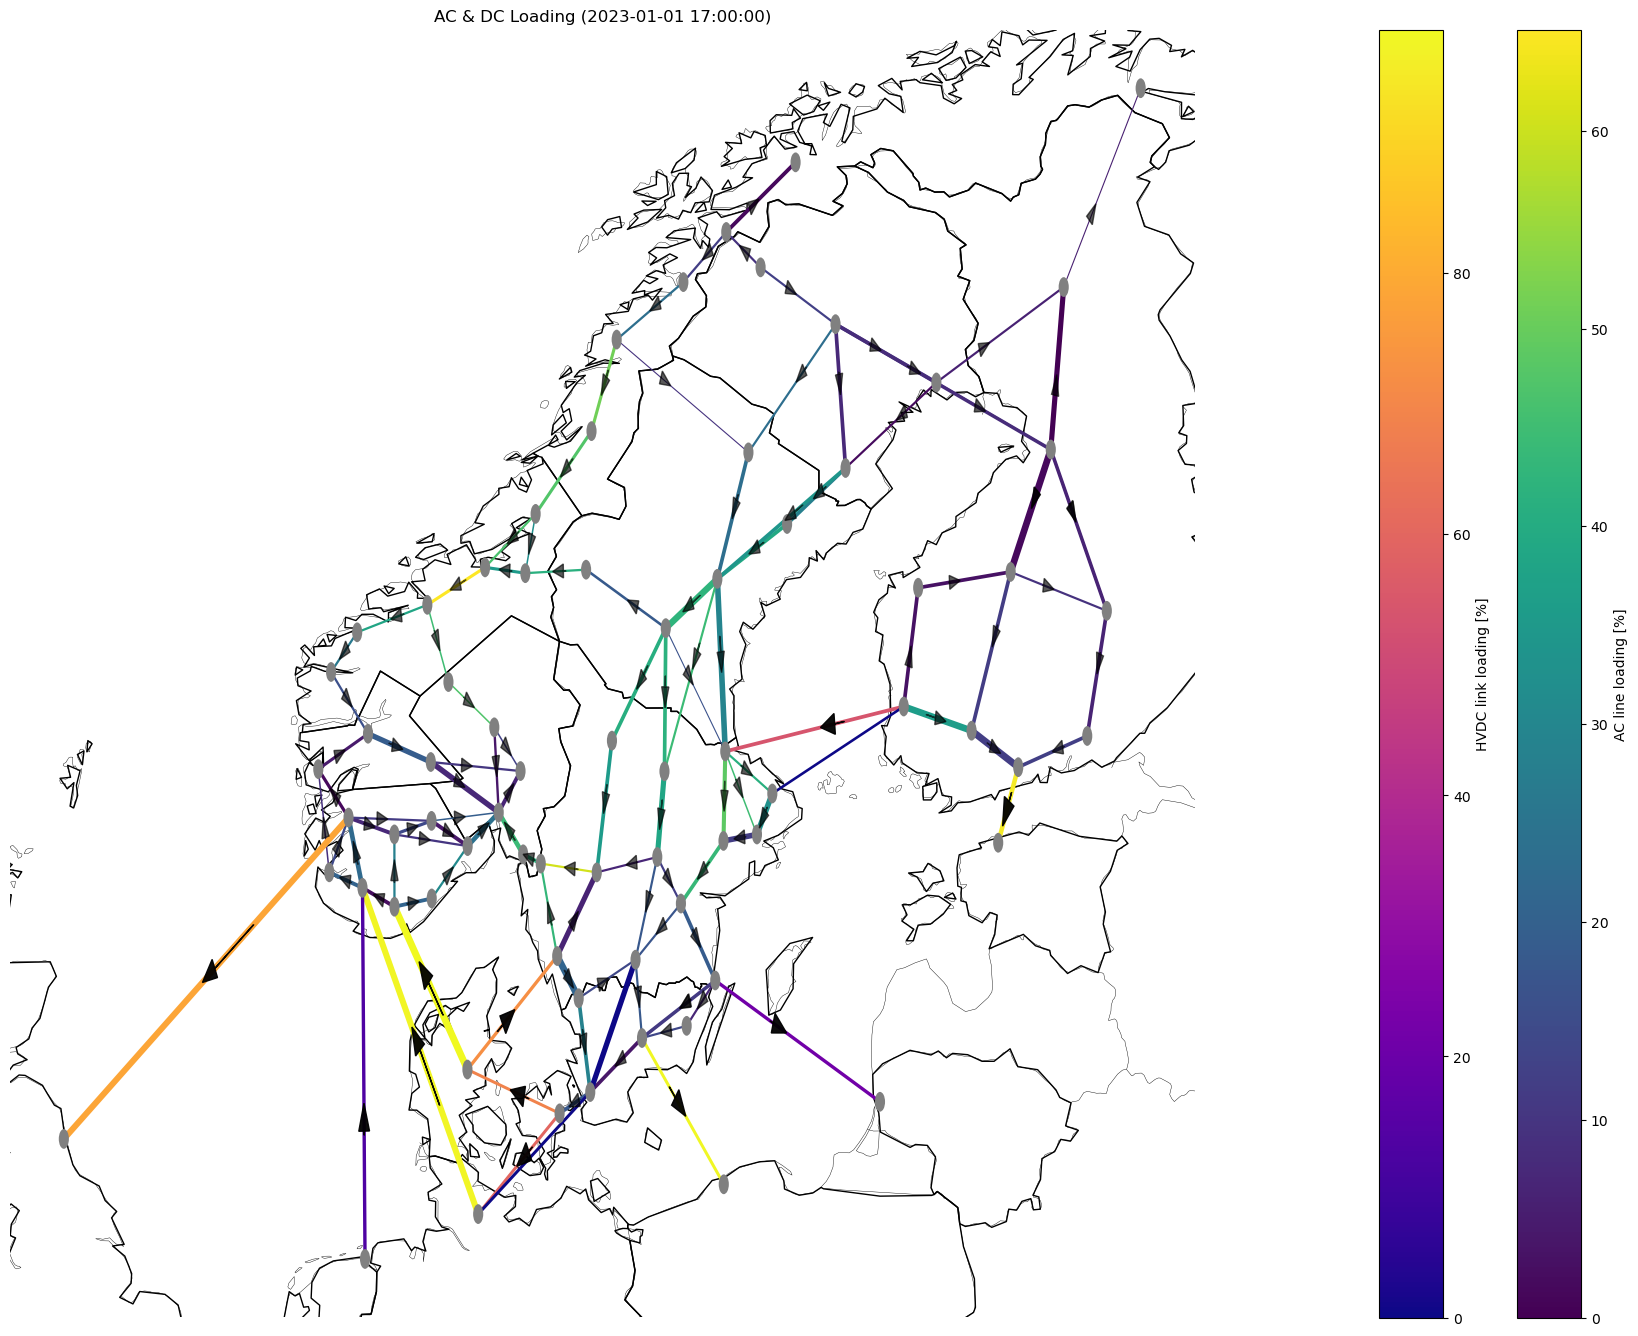

In [18]:
#Specify what max line capacity you want to use for normalization. 1 line in Finland is very capable, and if we don't specify normalization value ourselves, 
#the other lines look really small
plot_network_with_loadings(n, snapshot_number=17, normalization_val_lines=7500) 

In [19]:
print(n.lines_t.p0['57'])
n.buses.zone == 'NO_3'
n.buses[n.buses.zone == 'NO_3']

snapshot
2023-01-01 00:00:00   -178.281375
2023-01-01 01:00:00   -157.142922
2023-01-01 02:00:00   -144.363816
2023-01-01 03:00:00   -121.163045
2023-01-01 04:00:00    -87.117334
2023-01-01 05:00:00    -55.091416
2023-01-01 06:00:00   -102.516892
2023-01-01 07:00:00    -86.490544
2023-01-01 08:00:00    -61.595654
2023-01-01 09:00:00    -60.885927
2023-01-01 10:00:00    -71.500290
2023-01-01 11:00:00    -67.148049
2023-01-01 12:00:00    -61.399514
2023-01-01 13:00:00    -78.940650
2023-01-01 14:00:00   -176.065441
2023-01-01 15:00:00   -286.236760
2023-01-01 16:00:00   -460.736738
2023-01-01 17:00:00   -450.997818
2023-01-01 18:00:00   -503.187797
2023-01-01 19:00:00   -480.003041
2023-01-01 20:00:00   -464.145608
2023-01-01 21:00:00   -486.249331
2023-01-01 22:00:00   -501.575662
2023-01-01 23:00:00   -459.395007
Name: 57, dtype: float64


,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off,zone,load_share
Bus,,,,,,,,,,,,,,,,,,
NO1 12,380.0,,5.916951,61.826191,AC,,,1.0,0.0,inf,PQ,,1,NO,1.0,1.0,NO_3,0.166982
NO1 18,380.0,,11.633451,64.086361,AC,,,1.0,0.0,inf,PQ,,1,NO,1.0,1.0,NO_3,0.172584
NO1 21,380.0,,6.646529,62.393368,AC,,,1.0,0.0,inf,PQ,,1,NO,1.0,1.0,NO_3,0.114204
NO1 24,380.0,,10.220740,63.321684,AC,,,1.0,0.0,inf,PQ,,1,NO,1.0,1.0,NO_3,0.091650
NO1 6,380.0,,8.607228,62.786367,AC,,,1.0,0.0,inf,PQ,,1,NO,1.0,1.0,NO_3,0.338930
NO1 9,380.0,,11.345863,63.238799,AC,,,1.0,0.0,inf,PQ,,1,NO,1.0,1.0,NO_3,0.115650


In [20]:
# Group by bus + carrier and sum installed nominal power
capacity_by_bus_and_carrier = (
    n.generators
    .groupby(["bus", "carrier"])["p_nom"]
    .sum()
    .unstack(fill_value=0)
)

#print(capacity_by_bus_and_carrier)


In [21]:
# Ensure generators have zone mapped
n.generators["zone"] = n.generators["bus"].map(n.buses["zone"])

zone = "SE_3"

# Filter generators in that zone
gens_in_zone = n.generators[n.generators["zone"] == zone]

# Group by carrier → sum timeseries for each carrier separately
production_by_carrier = (
    n.generators_t.p[gens_in_zone.index]
    .groupby(gens_in_zone["carrier"], axis=1)
    .sum()
)

#print(production_by_carrier)



C:\Users\aleks\AppData\Local\Temp\ipykernel_58804\2939276344.py:12: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [22]:
a = n.generators_t.p_set

# Group by carrier (use mapping from generator names → carrier)
prod_per_carrier = a.groupby(n.generators["carrier"], axis=1).sum()

#print(prod_per_carrier.head(24))



C:\Users\aleks\AppData\Local\Temp\ipykernel_58804\633811106.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [23]:
prod_per_tech = gens_df.groupby(level="Technology", axis=1).sum()
#print(prod_per_tech.head(24))

#Do this for n.generators_t aswell to see slack production



C:\Users\aleks\AppData\Local\Temp\ipykernel_58804\1464202125.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [24]:
# Group time-dependent generation by carrier only
prod_per_carrier = (
    n.generators_t.p
    .groupby(n.generators["carrier"], axis=1)
    .sum()
)

# Show the first 24 timesteps
#print(prod_per_carrier.head(24))


C:\Users\aleks\AppData\Local\Temp\ipykernel_58804\3836803504.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Finding production for the slack generators. Just to see that something actually happens. 

In [25]:
# 1️⃣ Find buses without zone
buses_without_zone = n.buses[n.buses["zone"].isna() | (n.buses["zone"] == "")]
bus_list = buses_without_zone.index.tolist()

print(f"=== Buses without zone ({len(bus_list)}) ===")
print(bus_list)

# 2️⃣ Find generators connected to those buses
gens_without_zone = n.generators[n.generators["bus"].isin(bus_list)]

print(f"\n=== Generators connected to unzoned buses ({len(gens_without_zone)}) ===")
if gens_without_zone.empty:
    print("✅ No generators connected to unzoned buses.")
else:
    print(gens_without_zone[["bus", "carrier", "p_nom"]])

    # 3️⃣ Show their production time series
    # Choose either p (actual dispatch) or p_set (setpoint / target)
    gen_names = gens_without_zone.index
    production_ts = n.generators_t.p.loc[:, gen_names]

    print("\n=== Production of generators connected to unzoned buses ===")
    print(production_ts.head(24))  # first 24 hours (or snapshots)


n.generators.loc["slack_Forsmark"]

slack_gens = n.generators[n.generators["carrier"] == "slack"]
p_slack = n.generators_t.p[slack_gens.index]
slack_prod_per_zone = p_slack.groupby(slack_gens["zone"], axis=1).sum()

print(slack_prod_per_zone.head(100))

n.generators.columns

=== Buses without zone (6) ===
['DE', 'NL', 'GB', 'PL', 'LT', 'EE']

=== Generators connected to unzoned buses (6) ===
          bus carrier  p_nom
Generator                   
slack_DE   DE   slack    0.0
slack_NL   NL   slack    0.0
slack_GB   GB   slack    0.0
slack_PL   PL   slack    0.0
slack_LT   LT   slack    0.0
slack_EE   EE   slack    0.0

=== Production of generators connected to unzoned buses ===
Generator             slack_DE  slack_NL  slack_GB  slack_PL  slack_LT  \
snapshot                                                                 
2023-01-01 00:00:00  2015.1750  649.0900   -627.87    197.88   -525.83   
2023-01-01 01:00:00  1959.4275  649.0900   -178.78      6.69   -326.18   
2023-01-01 02:00:00  1975.3750  649.0900    270.90      0.00   -285.48   
2023-01-01 03:00:00  2111.7325  649.0900    713.15      0.00   -521.35   
2023-01-01 04:00:00  1971.4800  649.0900   1002.64      0.00   -406.59   
2023-01-01 05:00:00  2118.8275  649.0900   1013.98      0.00   -662.71

C:\Users\aleks\AppData\Local\Temp\ipykernel_58804\3491747872.py:30: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'e_sum_min',
       'e_sum_max', 'q_set', 'sign', 'carrier', 'marginal_cost',
       'marginal_cost_quadratic', 'active', 'build_year', 'lifetime',
       'capital_cost', 'efficiency', 'committable', 'start_up_cost',
       'shut_down_cost', 'stand_by_cost', 'min_up_time', 'min_down_time',
       'up_time_before', 'down_time_before', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down',
       'weight', 'p_nom_opt', 'zone', 'production_share'],
      dtype='object')

Testing cells below. For results. Power flow results sometimes differ wildly from the expected ones. Look at this together. 

In [26]:
import pandas as pd
import numpy as np

def compute_crossborder_flows_ac(n, snapshot_index=17):
    """
    Compute net cross-border AC flows (MW) between zones at a given snapshot index.
    Positive = net flow from zone0 → zone1 (direction based on alphabetical order of zones).
    """

    # --- Select snapshot ---
    snapshot = n.snapshots[snapshot_index]

    # --- Map buses to zones ---
    bus_zones = n.buses["zone"].to_dict()

    # --- AC lines that connect different zones ---
    line_df = n.lines.copy()
    line_df["zone0"] = line_df["bus0"].map(bus_zones)
    line_df["zone1"] = line_df["bus1"].map(bus_zones)

    cross_lines = line_df[line_df["zone0"] != line_df["zone1"]].copy()
    if cross_lines.empty:
        print("No cross-border AC lines found.")
        return pd.DataFrame()

    # --- Power flow (MW) for selected snapshot ---
    p0 = n.lines_t.p0.loc[snapshot, cross_lines.index]
    cross_lines["flow_MW"] = p0

    # --- Define *directed* pairs based on alphabetical order ---
    def ordered_flow(row):
        # Always order zones alphabetically to keep one direction per pair
        zoneA, zoneB = sorted([row["zone0"], row["zone1"]])
        # If the alphabetical order reverses original direction, invert sign
        sign = 1 if (row["zone0"] == zoneA) else -1
        return pd.Series({"zoneA": zoneA, "zoneB": zoneB, "flow_MW": row["flow_MW"] * sign})

    ordered = cross_lines.apply(ordered_flow, axis=1)

    # --- Sum up all lines between each zone pair ---
    flows = (
        ordered.groupby(["zoneA", "zoneB"])["flow_MW"]
        .sum()
        .rename("AC_flow_MW")
        .to_frame()
    )

    # --- Sort for readability ---
    return flows.sort_index()



In [27]:
flows = compute_crossborder_flows_ac(n, snapshot_index=22)

# Drop rows by integer position (row 1 and 2)
flows_dropped = flows.reset_index().drop([1, 2])

print("\n=== Cross-border flows (MW) ===")
print(flows_dropped)
flows_dropped.iloc[0,2]



=== Cross-border flows (MW) ===
   zoneA zoneB   AC_flow_MW
0   DK_2  SE_4  -659.247500
3   NO_1  NO_2 -1204.069297
4   NO_1  NO_3  -501.575662
5   NO_1  NO_5  -327.265431
6   NO_1  SE_3 -1671.459610
7   NO_2  NO_5   248.863203
8   NO_3  NO_4 -1302.275303
9   NO_3  NO_5   495.712228
10  NO_3  SE_2  -641.512587
11  NO_4  SE_1    22.063585
12  NO_4  SE_2    88.805649
13  SE_1  SE_2  2326.589048
14  SE_2  SE_3  5235.902110
15  SE_3  SE_4  2367.667500


-659.2474999999995

In [28]:
test = ac_flows_df.iloc[22]
test

DK_2<->SE_4    -725.28
NO_1<->NO_2   -1145.84
NO_1<->NO_3     -92.16
NO_1<->NO_5    -431.56
NO_1<->SE_3   -1934.39
NO_2<->NO_5     217.10
NO_3<->NO_4   -1229.33
NO_3<->NO_5     564.84
NO_3<->SE_2    -416.23
NO_4<->SE_1     105.46
NO_4<->SE_2      37.52
SE_1<->SE_2    2978.00
SE_2<->SE_3    6096.07
SE_3<->SE_4    2641.91
Name: 2023-01-01 22:00:00, dtype: float64

In [29]:
test.iloc[0]

-725.28

In [30]:
diff_list = []

for i in range(len(flows_dropped)):
    value = flows_dropped.iloc[i, 2] - test.iloc[i]
    diff_list.append(value)

# Convert to Series if you like:
diff_series = pd.Series(diff_list, index=flows_dropped.index)
print(diff_series)

0      66.032500
3     -58.229297
4    -409.415662
5     104.294569
6     262.930390
7      31.763203
8     -72.945303
9     -69.127772
10   -225.282587
11    -83.396415
12     51.285649
13   -651.410952
14   -860.167890
15   -274.242500
dtype: float64


In [31]:
# Percent deviation
diff_list = []

for i in range(len(flows_dropped)):
    value = (flows_dropped.iloc[i, 2] - test.iloc[i])/test.iloc[i] * 100
    diff_list.append(value)

# Convert to Series if you like:
diff_series = pd.Series(diff_list, index=flows_dropped.index)
print(diff_series)

avg = diff_series.mean()
print(avg)

0      -9.104415
3       5.081800
4     444.244425
5     -24.166876
6     -13.592419
7      14.630678
8       5.933745
9     -12.238470
10     54.124543
11    -79.078717
12    136.688829
13    -21.874109
14    -14.110204
15    -10.380463
dtype: float64
34.01131063707656


In [32]:
# Average error over the entire 24-hour period
aggregated_err = 0

for i in range(24):  # snapshot index 0–23
    # --- Modelled flow at snapshot i ---
    flows_i = compute_crossborder_flows_ac(n, snapshot_index=i)

    # --- Drop unwanted rows ---
    flows_dropped_i = flows_i.reset_index().drop([1, 2])

    # --- Actual measured flows for same snapshot ---
    actual_flow = ac_flows_df.iloc[i]   # Series of actual flows for all zone pairs

    # --- Add zone pair identifier for alignment ---
    flows_dropped_i["pair"] = flows_dropped_i["zoneA"] + "<->" + flows_dropped_i["zoneB"]
    flows_dropped_i = flows_dropped_i.set_index("pair")

    # --- Prepare for inner loop ---
    diff_list = []

    for j in range(len(flows_dropped_i)):
        pair_name = flows_dropped_i.index[j]

        # Skip if this pair not in actual data
        if pair_name not in actual_flow.index:
            continue

        model_val = flows_dropped_i.iloc[j, 2]          # "AC_flow_MW"
        actual_val = actual_flow.loc[pair_name]

        # Guard against divide-by-zero
        if actual_val == 0:
            continue

        # Percent deviation
        value = (model_val - actual_val) / abs(actual_val) * 100
        diff_list.append(value)

    # --- Convert differences to Series for this snapshot ---
    diff_series = pd.Series(diff_list)
    print(f"\n=== Snapshot {i} ===")
    print(diff_series)

    # --- Aggregate mean absolute error for this snapshot ---
    aggregated_err += diff_series.abs().mean()

# --- Average over 24 snapshots ---
avg_err = aggregated_err / 24
print("\nAverage percentage deviation across all snapshots:")
print(f"{avg_err:.2f}%")



=== Snapshot 0 ===
0      45.499393
1     -18.008977
2    -113.715386
3    -283.090540
4      10.417087
5      89.262802
6       8.275274
7     -76.623979
8       8.913205
9       6.402799
10     24.206992
11    -38.474597
12    -11.783656
13    -51.558436
dtype: float64

=== Snapshot 1 ===
0       87.022220
1        2.073800
2      -64.547562
3     -123.035813
4        8.127146
5     9729.074493
6        7.757851
7     -184.650436
8        6.898871
9        5.859443
10      20.023565
11     -36.329530
12     -12.095481
13     -37.613518
dtype: float64

=== Snapshot 2 ===
0      48.666761
1      13.270000
2     -60.457726
3     -74.461756
4       3.340617
5       1.128109
6    -332.183349
7       3.829046
8       7.482290
9      14.461461
10    -34.354643
11    -11.103312
12    -38.251470
dtype: float64

=== Snapshot 3 ===
0       12.768714
1       18.199900
2     -102.546047
3      -81.972455
4        3.094114
5       11.757207
6    -2236.643085
7        6.311153
8        6.187929
9 

In [33]:
import pandas as pd
import numpy as np

def compute_crossborder_flows_ac_2(n, snapshot_index=17):
    """
    Compute net cross-border AC flows (MW) between zones at a given snapshot index.
    Positive = net flow from alphabetically lower zone → higher zone.
    Includes list of contributing line IDs for each zone pair.
    """

    # --- Select snapshot ---
    snapshot = n.snapshots[snapshot_index]

    # --- Map buses to zones ---
    bus_zones = n.buses["zone"].to_dict()

    # --- Identify AC lines crossing different zones ---
    line_df = n.lines.copy()
    line_df["zone0"] = line_df["bus0"].map(bus_zones)
    line_df["zone1"] = line_df["bus1"].map(bus_zones)

    cross_lines = line_df[line_df["zone0"] != line_df["zone1"]].copy()
    if cross_lines.empty:
        print("⚠️ No cross-border AC lines found.")
        return pd.DataFrame()

    # --- Power flow (MW) for selected snapshot ---
    p0 = n.lines_t.p0.loc[snapshot, cross_lines.index]
    cross_lines["flow_MW"] = p0

    # --- Normalize direction by alphabetical order of zones ---
    def ordered_flow(row):
        zoneA, zoneB = sorted([row["zone0"], row["zone1"]])
        sign = 1 if row["zone0"] == zoneA else -1
        return pd.Series({
            "zoneA": zoneA,
            "zoneB": zoneB,
            "flow_MW": row["flow_MW"] * sign,
            "line_name": row.name
        })

    ordered = cross_lines.apply(ordered_flow, axis=1)

    # --- Group by zone pair: sum flow and collect line names ---
    flows = (
        ordered.groupby(["zoneA", "zoneB"])
        .agg(
            AC_flow_MW=("flow_MW", "sum"),
            lines_included=("line_name", lambda x: ", ".join(x))
        )
        .reset_index()
        .sort_values(["zoneA", "zoneB"])
        .set_index(["zoneA", "zoneB"])
    )

    return flows


In [34]:
flows = compute_crossborder_flows_ac_2(n, snapshot_index=17)
print(flows.reset_index())


   zoneA zoneB   AC_flow_MW          lines_included
0   DK_2  SE_4  -627.507500                       0
1     FI  NO_4    27.584401                      12
2     FI  SE_1  -507.554401                13, 8, 9
3   NO_1  NO_2 -1347.094408                  27, 29
4   NO_1  NO_3  -450.997818                      57
5   NO_1  NO_5  -611.245354                  18, 20
6   NO_1  SE_3 -1556.832420                      53
7   NO_2  NO_5   133.795592                  52, 58
8   NO_3  NO_4 -1367.692410                      43
9   NO_3  NO_5   297.039762                      31
10  NO_3  SE_2  -777.505170                      59
11  NO_4  SE_1  -166.190233                      34
12  NO_4  SE_2    46.732225                      42
13  SE_1  SE_2  2645.935365              70, 89, 96
14  SE_2  SE_3  5535.522420      62, 73, 74, 78, 97
15  SE_3  SE_4  2260.197500  65, 81, 82, 83, 91, 92


In [35]:
# Map each bus to its zone
bus_zones = n.buses["zone"].to_dict()

# Create columns for the zones of each end of the line
n.lines["zone0"] = n.lines["bus0"].map(bus_zones)
n.lines["zone1"] = n.lines["bus1"].map(bus_zones)

# Filter for lines where bus0 is in NO_2 and bus1 is in NO_5
mask = (n.lines["zone0"] == "SE_4") & (n.lines["zone1"] == "SE_3")
lines_NO2_NO5 = n.lines[mask]

print("=== Lines with bus0 in NO_2 and bus1 in NO_5 ===")
print(lines_NO2_NO5)


=== Lines with bus0 in NO_2 and bus1 in NO_5 ===
Empty DataFrame
Columns: [bus0, bus1, type, x, r, g, b, s_nom, s_nom_mod, s_nom_extendable, s_nom_min, s_nom_max, s_max_pu, capital_cost, active, build_year, lifetime, length, carrier, terrain_factor, num_parallel, v_ang_min, v_ang_max, sub_network, x_pu, r_pu, g_pu, b_pu, x_pu_eff, r_pu_eff, s_nom_opt, v_nom, i_nom, dc, zone0, zone1]
Index: []


In [36]:
line_no = '20'
print(n.lines_t.p0[line_no].iloc[17])
print(n.lines.loc[line_no])
print(n.buses.loc['NO1 0'])
#n.buses.zone == 'NO_3'
#n.buses[n.buses.zone == 'NO_3']

194.5012441275926
bus0                                      NO1 0
bus1                                      NO1 5
type                Al/St 240/40 4-bundle 380.0
x                                     30.742695
r                                      3.749109
g                                           0.0
b                                      0.000662
s_nom                               1876.850255
s_nom_mod                                   0.0
s_nom_extendable                           True
s_nom_min                           1876.850255
s_nom_max                          21876.850255
s_max_pu                                    0.7
capital_cost                          15.896673
active                                     True
build_year                                    0
lifetime                                    inf
length                               138.125075
carrier                                      AC
terrain_factor                              1.0
num_parallel          

Looking at how often the model calculates the correct direction of power flow. 

In [37]:
import numpy as np
import pandas as pd

# Track total and correct directions
total_count = 0
correct_count = 0

# Store per-snapshot accuracy (optional)
sign_accuracy = []

for i in range(24):  # assuming 24 snapshots
    # --- Modelled flows ---
    model_flows = compute_crossborder_flows_ac_2(n, snapshot_index=i)
    model_df = model_flows.reset_index()
    model_df["pair"] = model_df["zoneA"] + "<->" + model_df["zoneB"]
    model_df = model_df.set_index("pair")

    # --- Actual measured flows ---
    actual = ac_flows_df.iloc[i]

    # --- Align model and actual zone pairs ---
    common_pairs = model_df.index.intersection(actual.index)
    if common_pairs.empty:
        continue

    model_vals = model_df.loc[common_pairs, "AC_flow_MW"]
    actual_vals = actual.loc[common_pairs]

    # --- Compare signs ---
    sign_match = np.sign(model_vals) == np.sign(actual_vals)
    correct = sign_match.sum()
    total = len(sign_match)

    # --- Track results ---
    correct_count += correct
    total_count += total
    sign_accuracy.append(correct / total * 100)

    print(f"Snapshot {i:02d}: {correct}/{total} ({correct/total*100:.1f}%) correct directions")

# --- Overall accuracy ---
overall_accuracy = correct_count / total_count * 100
print("\n=== Directional accuracy summary ===")
print(f"Total matches: {correct_count}/{total_count}")
print(f"Overall accuracy: {overall_accuracy:.1f}%")

# Optional: average per-snapshot accuracy
print(f"Average per-snapshot accuracy: {np.mean(sign_accuracy):.1f}%")


Snapshot 00: 13/14 (92.9%) correct directions
Snapshot 01: 12/14 (85.7%) correct directions
Snapshot 02: 12/14 (85.7%) correct directions
Snapshot 03: 11/14 (78.6%) correct directions
Snapshot 04: 13/14 (92.9%) correct directions
Snapshot 05: 12/14 (85.7%) correct directions
Snapshot 06: 12/14 (85.7%) correct directions
Snapshot 07: 11/14 (78.6%) correct directions
Snapshot 08: 11/14 (78.6%) correct directions
Snapshot 09: 12/14 (85.7%) correct directions
Snapshot 10: 12/14 (85.7%) correct directions
Snapshot 11: 12/14 (85.7%) correct directions
Snapshot 12: 12/14 (85.7%) correct directions
Snapshot 13: 14/14 (100.0%) correct directions
Snapshot 14: 13/14 (92.9%) correct directions
Snapshot 15: 14/14 (100.0%) correct directions
Snapshot 16: 13/14 (92.9%) correct directions
Snapshot 17: 13/14 (92.9%) correct directions
Snapshot 18: 13/14 (92.9%) correct directions
Snapshot 19: 13/14 (92.9%) correct directions
Snapshot 20: 14/14 (100.0%) correct directions
Snapshot 21: 13/14 (92.9%) corr